# pump probe analysis for sxri0414 run 60

## initializing environment, data, and analysis configuration

### loading libraries

In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import filter_masks    #abstracts filter masks into config file
import pickle
from scipy import stats

In [2]:
import inspect

In [3]:
inspect.getsourcefile(filter_masks)

'/reg/neh/home5/sioan/Desktop/git_version_controlled/softXRayDataAndControls/experimentSpecificFiles/sxri0414/jupyter/filter_masks.py'

### loading data

In [2]:
#load data
experiment_run_name = "sxri0414run60"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../small_h5_data/"+my_file,"r")

### converting h5 to dictionary and loading into memory

In [3]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

### time tool pixel to femto second conversion

In [10]:
try:
    last_results = my_results.copy()
except:
    pass
#configuration parameters
time_tool_sign = 1
pixel_to_femtosecond = 0.0033444
#pixel_to_femtosecond = 0.002
delay_stage_offset = min(my_dict['delayStage'])

### validating data was loaded

In [11]:
#subplot(121)
#hist(my_dict['timeToolOpal/time_pixel'],bins=arange(0,600,6))
#subplot(122)
#plot(my_dict['ebeam/photon_energy'],my_dict['GMD'],'.')
#xlim(900,930)
#show()

## starting analysis

### applying masks to outlying data points

In [12]:
#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)
my_mask *=  (my_dict['ebeam/photon_energy']<920)
my_mask *=  (my_dict['ebeam/photon_energy']>912)
#my_mask *=  (my_dict['timeToolOpal/uncertainty_cov']*pixel_to_femtosecond<0.0002)

/reg/data/ana13/sxr/sxri0414/res/automated_analysis/jupyter_notebooks/filter_masks.py:14: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>1)


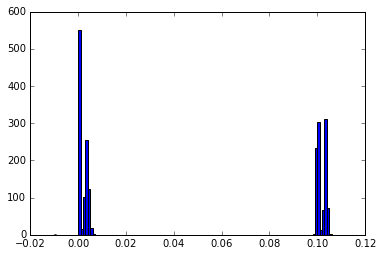

In [13]:
hist(2/.3*diff(my_dict['delayStage'])[(diff(my_dict['delayStage'])>0)],bins=arange(-.01,0.12,.001))
show()

### calculating pump probe axis from time tool

In [33]:
#TSS_OPAL/pixelTime = is the original psana type analyzed time tool data
#timeToolOpal/time_pixel = this is the custom analyzed time tool data using eigen backgrounds
#my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['TSS_OPAL/pixelTime']-mean(my_dict['TSS_OPAL/pixelTime'][my_mask]))*pixel_to_femtosecond )
my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['timeToolOpal/time_pixel']-mean(my_dict['timeToolOpal/time_pixel'][my_mask]))*pixel_to_femtosecond )

In [34]:
#subplot(121)
#plot(my_dict['GMD'][my_mask],my_dict['acqiris2/amplitude'][my_mask],'.')
#ylim(-0.1,1)
#subplot(122)
#hist(my_dict['TSS_OPAL/pixelTime'][my_mask]*pixel_to_femtosecond,bins=arange(0.6,2.0,0.001))
#show()

In [35]:
#subplot(121)
#hist(abs(my_dict['timeToolOpal/uncertainty_cov'])**0.5,bins=arange(-0.1,1,0.01))
#subplot(122)
#hist(abs(my_dict['timeToolOpal/time_pixel']),bins=arange(200,550,4))
#show()

### placing data in x,y,z variables so don't have to use full dictionary

In [36]:
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

In [37]:
#putting data into shorter variables cause I'm tired of typing. 
#also, variable x is corrected for the energy shift artifact
x = (my_dict['GMD']*gaussian(my_dict['ebeam/photon_energy'],913.765,2.128,1)/gaussian(my_dict['ebeam/photon_energy'],913.269,2.16,1) )[my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
z = my_dict['corrected_time'][my_mask]
myValues = array([x,y,z,sy]).transpose()
#my_bins = arange(-6.0,35,0.065)
my_bins = arange(-6.0,35,0.02)              #creating the bins for the pump probe axis

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

def quartile_std(x):
    return std(stats.trimboth(x, 0.25))

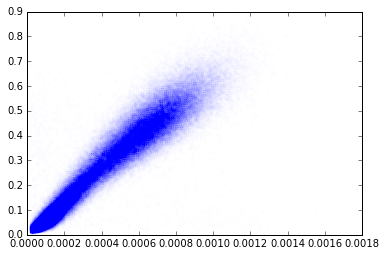

In [38]:
plot(x,y,'.',alpha=0.003)
show()

## the pump probe analysis

### plotting binned pump probe for average,quartile_mean, for weighted and un weighted statistics

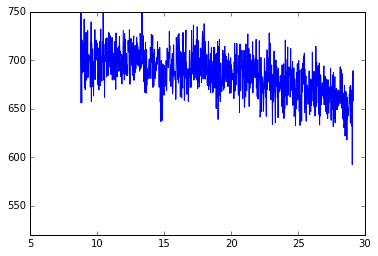

In [39]:
#removing the vectorized custom binned statistic and replacing with supported one
#first one below is the unweighted average
binned_acqiris = binned_statistic_dd(z,y,bins=[my_bins],statistic=average)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=average)
#plot(my_bins[:-1],(binned_acqiris.statistic/binned_GMD.statistic)[::-1])

#the one below is the weighted average
binned_weighted_acqiris = binned_statistic_dd(z,y/sy,bins=[my_bins],statistic=average)
binned_weights = binned_statistic_dd(z,1.0/sy,bins=[my_bins],statistic=average)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=average)
#plot(my_bins[:-1],(binned_weighted_acqiris.statistic/binned_weights.statistic/binned_GMD.statistic)[::-1])

#the one below is the trunctated mean
binned_acqiris = binned_statistic_dd(z,y,bins=[my_bins],statistic=quartile_mean)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=quartile_mean)
plot(my_bins[:-1],(binned_acqiris.statistic/binned_GMD.statistic)[::-1])

#shot be shot
binned_weighted_acqiris_div_GMD = binned_statistic_dd(z,(y/x),bins=[my_bins],statistic=quartile_mean)
#plot(my_bins[:-1],(binned_weighted_acqiris_div_GMD.statistic)[::-1])

#ylim(96,118)
ylim(520,750)
#xlim(12,24)
show()


#### correcting for noise contribution and for how far from the middle a point falls within a bin.  Points falling close to the edge of the bin contribute more to their neighbors

In [40]:
#one of the problems with binning is that points falling at the edge of only contribue to the bin they fall into. 
#This section adds a weighting for the distance from the bin edge. if a point falls on the edge of the bin, 
#it contributes only marginally to that bin and majority to the other bin

def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

def binned_statistic_edge_corrected(x,y,sy,bins,statistic):
    #calculate two binned statistics
    bin_size = mean(diff(my_bins))
    bin_axis_weighting1 = (x%bin_size)
    
    #binned_data1 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    
    #binned_data1 = weighted_binned_statistic(x,y,bin_axis_weighting1,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,(bin_size-bin_axis_weighting1),bins,statistic)
    
    binned_data1 = weighted_binned_statistic(x,y,1.0/sy*bin_axis_weighting1,bins,statistic)
    binned_data2 = weighted_binned_statistic(x+1*bin_size,y,1.0/sy*(bin_size-bin_axis_weighting1),bins,statistic)
    #is the shift on x in the line immediately above correct?
  
    return (binned_data1+binned_data2)/2
    
#this calculates the noise from the binned statistic. still in progress
def binned_statistic_edge_corrected_noise(x,y,sy,bins,statistic):
    #calculate two binned statistics
    bin_size = mean(diff(my_bins))
    bin_axis_weighting1 = (x%bin_size)
    
    #binned_data1 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    
    #binned_data1 = weighted_binned_statistic(x,y,bin_axis_weighting1,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,(bin_size-bin_axis_weighting1),bins,statistic)
    
    binned_data1 = weighted_binned_statistic(x,y,1.0/sy*bin_axis_weighting1,bins,statistic)
    binned_data2 = weighted_binned_statistic(x+1*bin_size,y,1.0/sy*(bin_size-bin_axis_weighting1),bins,statistic)
    #is the shift on x in the line immediately above correct?
  
    return (binned_data1+binned_data2)/2
    

#### technique to avoid recalculating binned statistics from scratch. The binned statistic is calculated once for fine binning. Larger bin sizes are rebinned from the smaller bins.

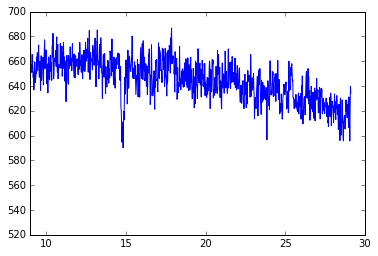

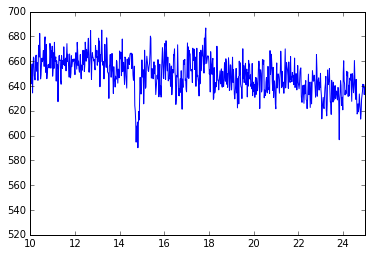

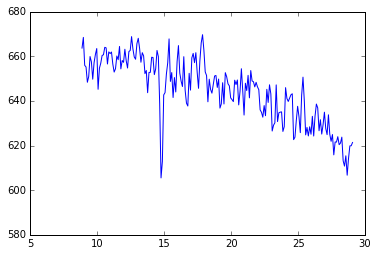

In [21]:
def rebin(x,bin_size):
    y = array([i for i in x if (i is not nan)])
    return convolve(y,ones(bin_size)*1.0/bin_size)[::bin_size]

edge_corrected_data = binned_statistic_edge_corrected(z,y,sy,bins=[my_bins],statistic=average)/binned_statistic_edge_corrected(z,x,ones(len(x)),bins=[my_bins],statistic=average)
plot(my_bins[:-1],edge_corrected_data[::-1])
ylim(520,700)
xlim(9,30)
show()
plot(my_bins[:-1],edge_corrected_data[::-1])
ylim(520,700)
xlim(10,25)
show()

bin_size = 5
plot(rebin(my_bins[:-1],bin_size),rebin(edge_corrected_data[::-1],bin_size))
ylim(580,680)
#xlim(10,25)
show()

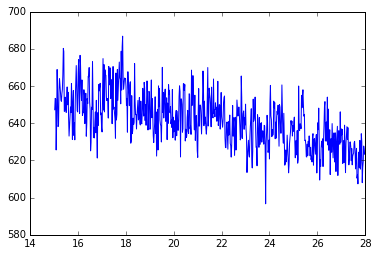

In [22]:
temp_mask = my_bins[:-1]>15
temp_mask *=  my_bins[:-1]<28
plot(my_bins[:-1][temp_mask],edge_corrected_data[::-1][temp_mask])
ylim()
show()

### calculating fourier transforms

#### uniform fourier transform

0.154083204931


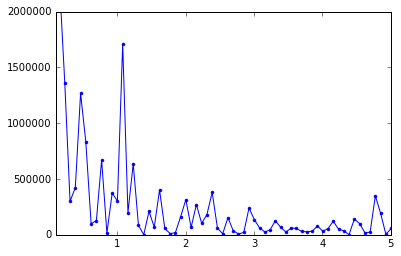

In [23]:
my_fft=(abs(fft(edge_corrected_data[::-1][temp_mask]))**2)[:int(sum(temp_mask/2))]

df = 1.0/(max(my_bins[:-1][temp_mask])-min(my_bins[:-1][temp_mask]))
peak_frequency = (argmax(my_fft[2:])+2)*df
print(peak_frequency)

plot(arange(len(my_fft))*df,my_fft,'.-')
#semilogx()
ylim(1e2,2e6)
xlim(.1,5)
show()

#### non uniform fourier transform

In [24]:
#x = (my_dict['GMD']*gaussian(my_dict['ebeam/photon_energy'],913.765,2.128,1)/gaussian(my_dict['ebeam/photon_energy'],913.269,2.16,1) )[my_mask]
#y = my_dict['acqiris2/amplitude'][my_mask]
#z = my_dict['corrected_time'][my_mask]
def get_fourier_projection(y,w):
    my_cov_cos = cov(y,cos(w))
    my_cov_sin = cov(y,sin(w))
    return my_cov_cos[0,1]/(my_cov_cos[1,1]+1e-12)+1j*my_cov_sin[0,1]/(my_cov_sin[1,1]+1e-12)


def non_uniform_fourier_transform(y_array,t_array,f_array):
    t_pi = 2 * 3.14159
    my_counter = 0 
    my_ft_value = []
    
    for f in f_array:
        my_counter += 1
        if(my_counter%500==1):
            print(str(my_counter)+", ")
        my_projection = get_fourier_projection(y_array,t_pi*f*t_array)
        
        my_ft_value.append(my_projection)
        
    my_ft_value = array(my_ft_value)
        
    return my_ft_value
    

In [25]:
fStep = 1.0/(max(z) - min(z))
f_axis = exp(arange(-log(1000*fStep),log(1000*fStep),log(1000*fStep)/1000.0))
temp_mask = z<15

In [26]:
my_ft = non_uniform_fourier_transform(y[temp_mask]*1.0/x[temp_mask],z[temp_mask],f_axis)

1, 
501, 
1001, 
1501, 


In [27]:
#my_ft_ref = non_uniform_fourier_transform(1.0*ones(sum(temp_mask)),z[temp_mask],f_axis)
my_ones = 1.0e3*ones((sum(temp_mask)))+1e-5*rand(sum(temp_mask))
my_ft_ref = non_uniform_fourier_transform(my_ones,z[temp_mask],f_axis)

1, 
501, 
1001, 
1501, 


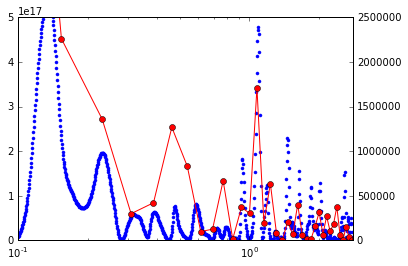

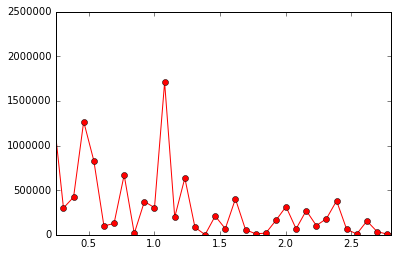

In [28]:
#unbinned fourier transform with sampling correction
plot(f_axis,abs(my_ft)**2/(abs(my_ft_ref)**2+(1e-8)**2),'.')
ylim(0,0.5e18)
xlim(0.1,10.1)
twinx()
plot(arange(len(my_fft))*df,my_fft,'ro-')
ylim(0,2.5e6)
xlim(0.1,2.8)
semilogx()
show()

#saving example
test_data = array([arange(len(my_fft))*df,(my_fft)])
savetxt("60_nonb.dat",test_data)
#savetxt("test_b.dat",arange(len(my_fft))*df,my_fft)
imported_data = loadtxt("60_nonb.dat")
#imported_data1 = loadtxt("test_b.dat")
plot(imported_data[0],imported_data[1], 'ro-')
#semilogx()
ylim(0,2.5e6)
xlim(0.25,2.8)
show()


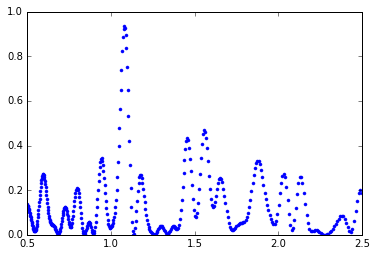

2000


In [29]:
#unbinned fourier transform compared to binned ft
plot(f_axis,abs(my_ft)**2/68,'.')
ylim(0,1)
xlim(0.5,2.5)
#twinx()
#plot(arange(len(my_fft))*df,my_fft,'ro-')
#xlim(0.45,2)
#ylim(0,2.5e6)
#semilogx()
show()
print(len(my_ft))

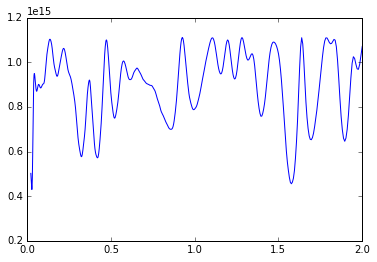

In [30]:
#contribution of samping sampling correction.
plot(f_axis,1.0/(abs(my_ft_ref)**2+(3e-8)**2))
xlim(0,2.0)
show()

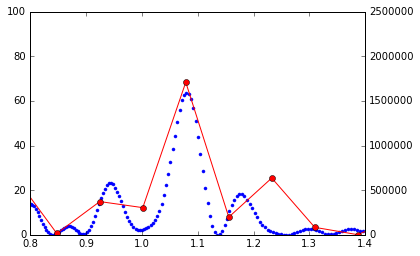

In [31]:
#unbinned fourier transform compared to binned ft
plot(f_axis,abs(my_ft)**2,'.')
ylim(0,100)
xlim(0.1,2)
twinx()
plot(arange(len(my_fft))*df,my_fft,'ro-')
xlim(0.8,1.4)
ylim(0,2.5e6)
#semilogx()
show()


In [32]:
print(f_axis[200:1200])

[ 0.04656139  0.04674024  0.04691977  0.0471      0.04728091  0.04746252
  0.04764483  0.04782784  0.04801155  0.04819596  0.04838109  0.04856693
  0.04875348  0.04894074  0.04912873  0.04931744  0.04950687  0.04969703
  0.04988792  0.05007954  0.0502719   0.050465    0.05065884  0.05085343
  0.05104876  0.05124484  0.05144168  0.05163927  0.05183762  0.05203673
  0.05223661  0.05243726  0.05263867  0.05284086  0.05304383  0.05324758
  0.0534521   0.05365742  0.05386352  0.05407042  0.0542781   0.05448659
  0.05469588  0.05490597  0.05511687  0.05532858  0.0555411   0.05575444
  0.0559686   0.05618358  0.05639938  0.05661602  0.05683348  0.05705179
  0.05727093  0.05749091  0.05771174  0.05793341  0.05815594  0.05837932
  0.05860356  0.05882866  0.05905463  0.05928146  0.05950917  0.05973775
  0.05996721  0.06019755  0.06042877  0.06066088  0.06089389  0.06112779
  0.06136258  0.06159828  0.06183489  0.0620724   0.06231083  0.06255017
  0.06279043  0.06303161  0.06327372  0.06351676  0

In [45]:
print(abs(my_ft[0:2000]))

[ 47.59527567  47.54472836  47.49489347 ...,   3.01449944   1.0732837
   0.91902719]
